In [1]:
%config InlineBackend.figure_format ='retina'

import pandas
import requests
import json
import re
from bs4 import BeautifulSoup

import numpy as np
import pandas
import matplotlib.pyplot as plt
import mysql.connector

In [329]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

def moving_window(series, w_size, lag, w=None):
    p95 = []
    p5 = []
    for i in range(w_size+lag, len(series)):
        s = series[i-lag-w_size:i-lag]
        if w:
            p = weighted_quantile(s, [0.975, 0.025], sample_weight=w)
        else:
            p = weighted_quantile(s, [0.95, 0.05])
        p95.append(p[0])
        p5.append(p[1])
    return series[w_size+lag:], np.array(p95), np.array(p5)

def proc(series, w_size, lag):
    ret = []
    for i in range(len(series)-lag-w_size):
        rr = 0.05
        yingli = ((series[i+lag:i+lag+w_size] - series[i]) > rr * series[i]).any()
        if not yingli:
            yingli = np.percentile(series[i+lag:i+lag+w_size] - series[i], 5)
        else:
            yingli = rr
        ret.append(yingli)
    return np.array(ret)
def auto_invest(series):
    ts = []
    ta = []
    ti = []
    total_share = 0
    total_asset = 0
    total_in = 0
    invest = 100
    for i in range(len(series)):
        share = (invest - invest * 0.015) / series[i]
        total_share += share
        total_asset = total_share * series[i]
        total_in += invest
        ts.append(total_share)
        ta.append(total_asset)
        ti.append(total_in)
    return np.array(ts), np.array(ta), np.array(ti)
    

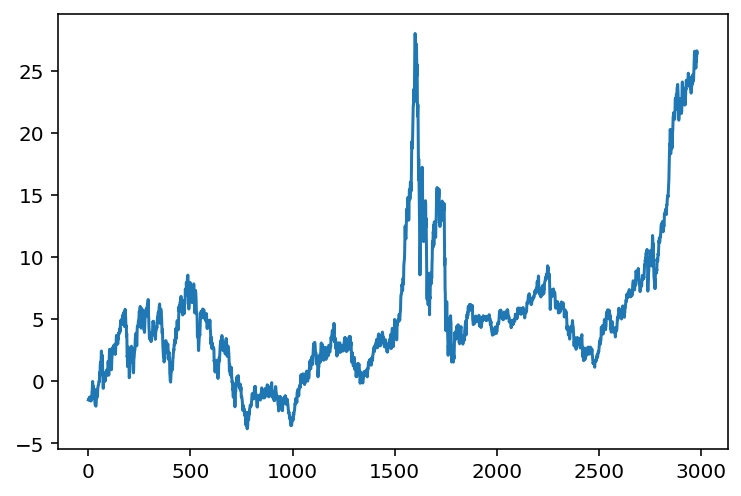

In [337]:
mycursor.execute("SELECT * FROM DAILY_NET_VALUE WHERE FUND_ID = '110012' ORDER BY REPORT_DATE DESC")
myresult = mycursor.fetchall()
df = pandas.DataFrame(myresult)
ss = df.iloc[:,3]
ss = list(reversed(ss))

s,a,i = auto_invest(ss)

plt.plot((a-i)/i * 100)